In [2]:
import pandas as pd
import numpy as np
import glob, time, os, cv2, csv

try:
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=0
except NameError:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())  ## to use which GPU in use


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8115494150705479295
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7341937167869918763
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10817833157109737742
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10812430746
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15140023996678689967
physical_device_desc: "device: 0, name: 

In [3]:
##Loading the model
model = load_model('/home/Erdal.Genc/covid_work/Padchest_work/')
print('Model has been loaded')

Model has been loaded


In [4]:

df_path = '/home/Erdal.Genc/covid_work/PadChest_csv/Padchest_filtered_withPath.csv'
df = pd.read_csv(df_path, low_memory= False)

In [69]:
# Display

# img_ = '/mnt/dsets/ChestXrays/PadChest/image_zips/0/99744230716892055301280916536204938895_oo9nk5.png'

index = 780
label = df['new_labels'][index]
img_ = df['Path'][index]
print(label, '\n', img_)
last_conv_layer_name = 'res5c_branch2c'

atelectasis, infiltration, pneumonia 
 /mnt/dsets/ChestXrays/PadChest/image_zips/0/304951933768483364013857833804927019063_blxqwd.png


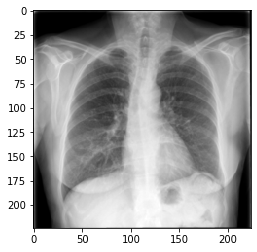

In [70]:
from PIL import Image
from skimage.transform import resize

_img = Image.open(img_)

img = np.asarray(_img)
# img = img/225.0
dim = (224,224)
img = resize(img, dim)
plt.imshow(np.abs(img), cmap = 'gray')
plt.show()
img_ready = np.stack((img,)*3, axis=-1) ## converts 1-Channel to 3-Channel image
img_ready = img_ready.reshape((1, *img_ready.shape))
y_pred = model.predict(img_ready)


In [71]:
images = tf.Variable(img_ready, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

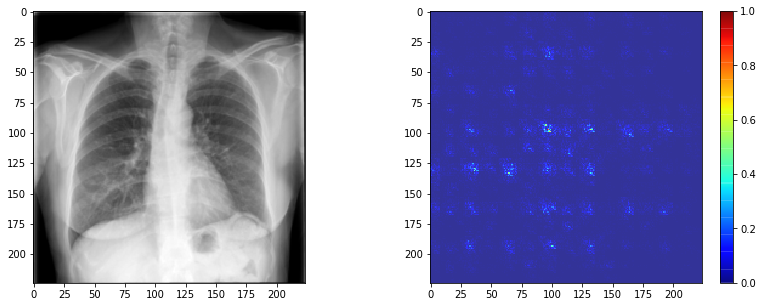

In [72]:
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].imshow(np.abs(img), cmap = 'gray')
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

In [58]:
img1 = Image.fromarray(img)
img2 = Image.fromarray(grad_eval)
new = img1.paste(img2, (0,0))


None
